This script describes how to load the condensed json versions of the Gaussian process (GP) interpolation models described in [link to paper]. The models are originally made using the `scikit-learn` Gaussian process regressor module. The json versions are much more storage-efficient and simply load the hyperparameters of the trained models into a newly instantiated GP regressor object. The documentation for the `scikit-learn` GP can be found at https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html.

The models are first organized into different families by viewing angle. Each viewing angle directory contains time-step subdirectories which host the optimized hyperparameters for interpolation at the given time step. The final light curve product is produced by "stitching together" the separate predictions produced from the interpolators at each separate time step. 

The example below shows how to load the models for the pole-on viewing angle bin (between 0 and 15.64 degrees) and create a prediction for an off-sample parameter combination. The final light curve is stitched together from the separate time step predictions. The light curve output can be compared to the bottom half of Figure 4 in [link to paper].

This script can be generally applied to all viewing angle model families. It is also capable of generating a light curve using only a subset of the time steps in the respective viewing angle directory.

In [1]:
import os, glob
os.environ["OMP_NUM_THREADS"] = "12"
from natsort import natsorted
import numpy as np
import save_sklearn_gp as ssg

Inputs for generating LCs

In [2]:
# making a size (9, 5) array with each row having 5 input parameters (md, vd, mw, vw, wav) for all wavelength bands
# Hotokezaka's model parameters : m_ej, v_ej, rho ~ v^-(power law), k opacity coefficients (alpha max ~ 2*vej , and min ~ 0.2*vej).
# range of inputs needs to be specified here: [0.001,0.1] ; velocities: [0.05,0.3]
# inputs = np.array([m_ejecta_dynamical, v_ejecta_dynamical, m_ejecta_wind, v_ejecta_wind])
# inputs = np.array([0.097050, 0.197642, 0.083748, 0.297978])
inputs = np.array([0.097050, 0.197642, 0.083748, 0.297978]) # parameters used for off-sample prediction in Figure 4 of paper
wavs = np.array([476., 621., 754., 900., 1020., 1220., 1630., 2190.]).reshape(8, 1) # wavelength bands in [nanometers]
angle = '00' # '00', '30', '45', '60', '75', or '90'
morphology = 'TorusPeanutWind2' # 'TorusPeanutWind1', 'TorusPeanutWind2', 'TorusSphericalWind1', 'TorusSphericalWind2'

inputs = np.tile(inputs, wavs.shape[0]).reshape(-1, 4)
inputs = np.hstack((inputs, wavs))  # shape: (8,5) ; each row has the same ejecta parameters and a new wavelength.

In [3]:
inputs

array([[9.70500e-02, 1.97642e-01, 8.37480e-02, 2.97978e-01, 4.76000e+02],
       [9.70500e-02, 1.97642e-01, 8.37480e-02, 2.97978e-01, 6.21000e+02],
       [9.70500e-02, 1.97642e-01, 8.37480e-02, 2.97978e-01, 7.54000e+02],
       [9.70500e-02, 1.97642e-01, 8.37480e-02, 2.97978e-01, 9.00000e+02],
       [9.70500e-02, 1.97642e-01, 8.37480e-02, 2.97978e-01, 1.02000e+03],
       [9.70500e-02, 1.97642e-01, 8.37480e-02, 2.97978e-01, 1.22000e+03],
       [9.70500e-02, 1.97642e-01, 8.37480e-02, 2.97978e-01, 1.63000e+03],
       [9.70500e-02, 1.97642e-01, 8.37480e-02, 2.97978e-01, 2.19000e+03]])

Light curve data being pulled from the Surrogates:

In [4]:
def load_surrogate_models(files):
	models = np.empty([0])
	i=0
	for file in files:
		fname = file+'/model'
		models = np.append(models,ssg.load_gp(fname)) # loading Gaussian Process from hyperparameters saved in .json format
	return models

In [5]:
def interpolate_light_curves(models, inputs):
	#import pdb; pdb.set_trace()
	for i in range(len(models)):
		pred, err = ssg.predict(models[i], inputs, output='mags')
		try:
			lc = np.append(lc, pred[None, :], axis=0)
			errs = np.append(errs, err[None, :], axis=0)
		except NameError:
			lc = pred[None, :] # if first time point, initializes the light curve array
			errs = err[None, :] # same as above, but for errors
	return lc, errs

In [6]:
#del lcs, errss
# loading all the models from the family trained using a pole-on viewing angle
files = glob.glob('surrogate_data/2021_Wollaeger_'+morphology+'/theta'+angle+'deg/*')
files = natsorted(files) # sorting is necessary! otherwise time will be out of order

models = load_surrogate_models(files)

In [7]:
lc, errs = interpolate_light_curves(models, inputs)

Plotting the lightcurves:

In [8]:
def flip(items, ncol):
    '''
    credit to Avaris on StackOverflow for this function
    Needed to arrange the legend on the plot in a nice external box above the plot.
    '''
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

In [9]:
from matplotlib import ticker
import matplotlib.pyplot as plt
import itertools

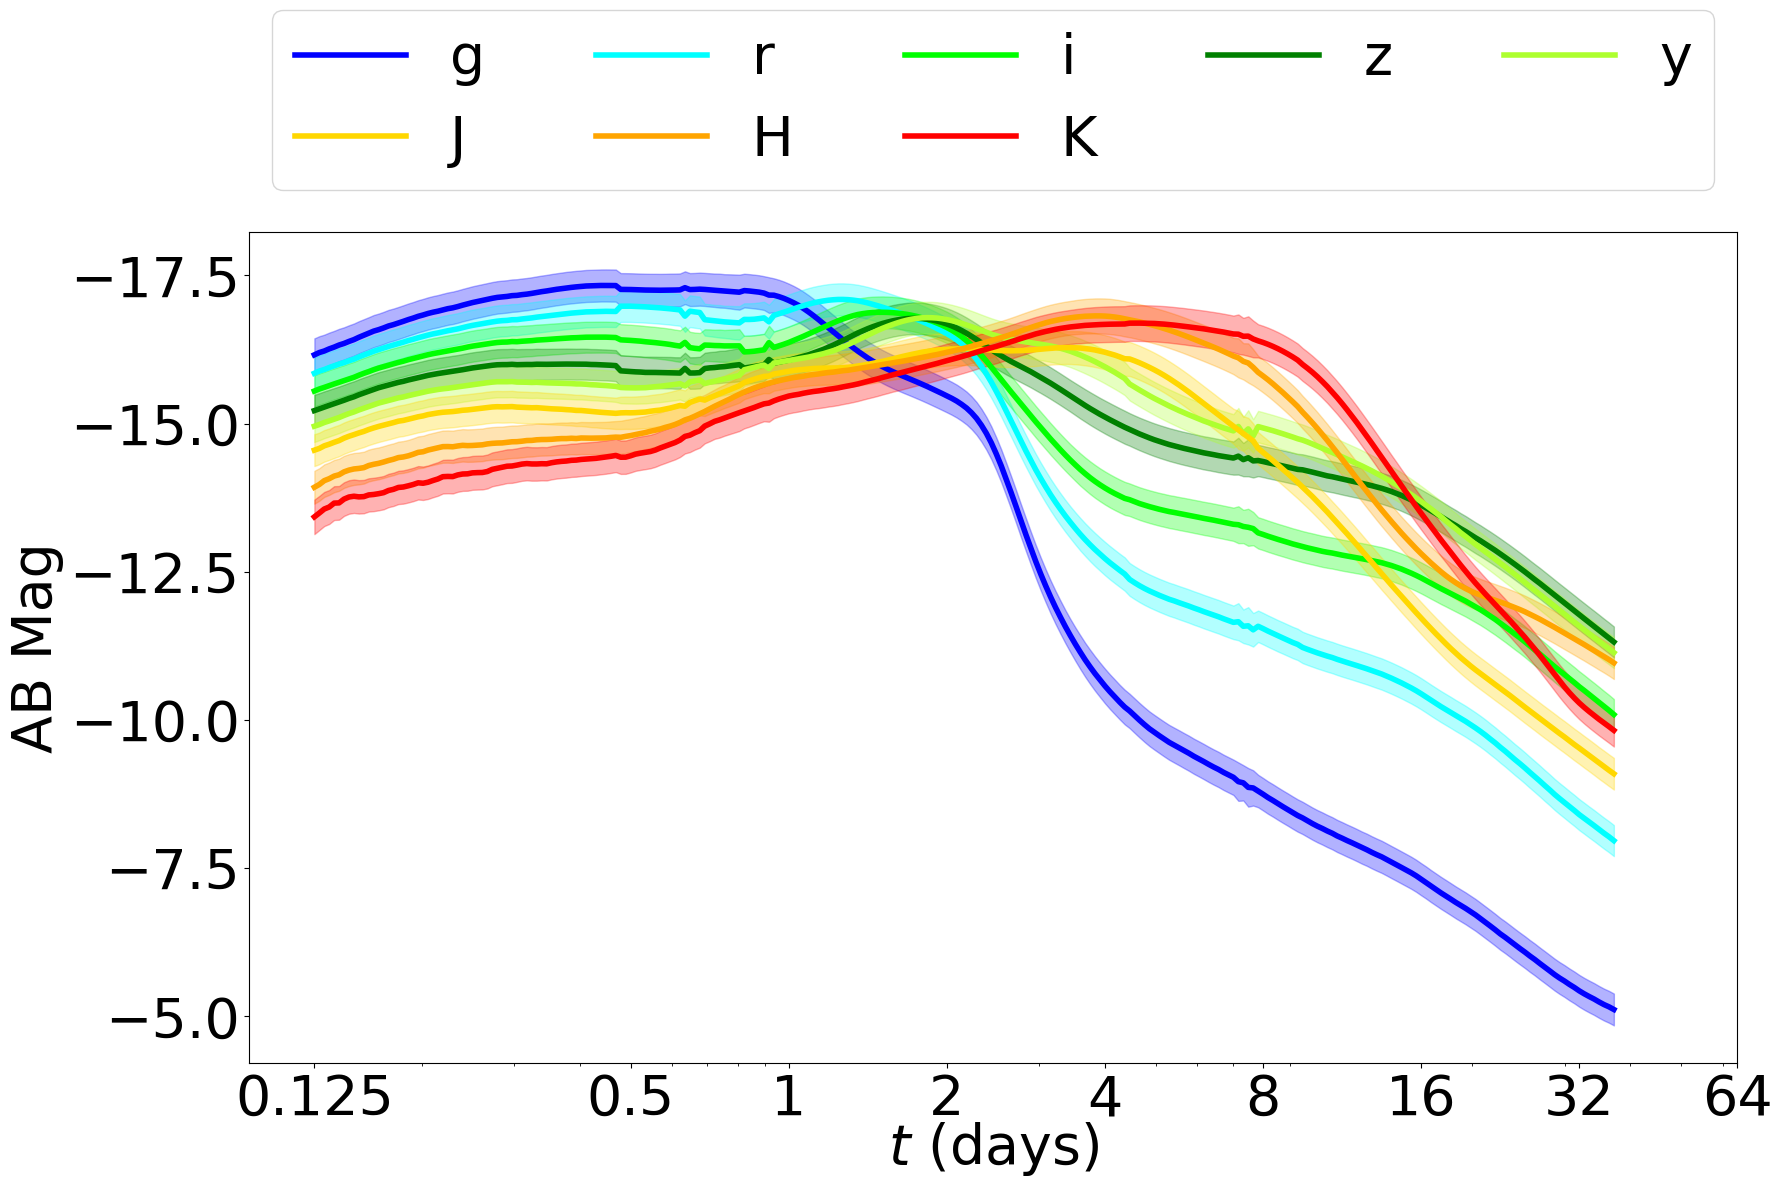

In [10]:
times = np.logspace(np.log10(0.125), np.log10(37.239195485411194), 264) # time in days hardcoded because this is the range chosen for
                                                                        # extracting spectra data

colors = {"g": "blue", "r": "cyan", "i": "lime", "z": "green", "y": "greenyellow", "J": "gold",
         "H": "orange", "K": "red", "S": "darkred"}
wavelengths = 'grizyJHKS'
plt.figure(figsize=(19.2, 10.8))
plt.rc('font', size = 40)
plt.rc('lines', lw=4)
for band in range(lc.shape[1]):
	plt.plot(times, lc[:, band], color=colors[wavelengths[band]], label=wavelengths[band])
	plt.fill_between(times, lc[:, band]-errs[:, band], lc[:, band]+errs[:, band], color=colors[wavelengths[band]], alpha=0.3)

plt.xscale('log')
plt.gca().set_xticks([0.125, 0.5, 1, 2, 4, 8, 16, 32, 64])
plt.gca().get_xaxis().set_major_formatter(ticker.FormatStrFormatter('%g'))
plt.xlabel(r"$t$ (days)", labelpad=-5)
plt.ylabel("AB Mag")
plt.gca().invert_yaxis()
handles, labels = plt.gca().get_legend_handles_labels()
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(flip(handles, 5), flip(labels, 5), ncol=5, bbox_to_anchor=(0.5, 1.3), loc='upper center')
plt.savefig('pred_compact.png')